In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Using Multi-modular Gemini to classify sources of astrophysical origin 

<table align="left">
 <td style="text-align: center">
   <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/notebook_template.ipynb">
     <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Open in Colab
   </a>
 </td>
 <td style="text-align: center">
   <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fnotebook_template.ipynb">
     <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
   </a>
 </td>   
 <td style="text-align: center">
   <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/notebook_template.ipynb">
     <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
   </a>
 </td>
 <td style="text-align: center">
   <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/notebook_template.ipynb">
     <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
   </a>
 </td>
</table>


In [2]:
import gdown 
import base64
import pylab
import json
import random
import time

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import vertexai
from vertexai.generative_models import GenerativeModel, Part, FinishReason, Image
import vertexai.preview.generative_models as generative_models
from google.cloud import bigquery

In [2]:
generation_config = {
    "max_output_tokens": 2048,
    "temperature": 0.7,
    "top_p": 1,
    "top_k": 32,
    "response_mime_type": "application/json",
}

safety_settings = {
    generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_ONLY_HIGH,
    generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_ONLY_HIGH,
    generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_ONLY_HIGH,
    generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_ONLY_HIGH,
}

def generate(prompt):
  vertexai.init(project="turan-genai-bb", location="us-central1")
  model = GenerativeModel(
    "gemini-1.5-pro-001",
  )
  responses = model.generate_content(
      prompt,
      generation_config=generation_config,
      safety_settings=safety_settings,
      stream=False,
  )

  return responses

def create_ex(data_index):   
    str_new = "new image: "
    str_ref = "reference image: "
    str_dif = "difference image: "
    
    image1 = Part.from_image(Image.load_from_file(f"pics/Example_{data_index}_fig_0.png"))
    image2 = Part.from_image(Image.load_from_file(f"pics/Example_{data_index}_fig_1.png"))
    image3 = Part.from_image(Image.load_from_file(f"pics/Example_{data_index}_fig_2.png"))
    return [str_new, image1, str_ref, image2, str_dif, image3]

def preprocess(nd_array, label_array, index_no):
  """Preprocesses a pair of images from a dataset for analysis.
  This function takes a multi-dimensional array containing image data, a corresponding array of labels, and an index. It then:

  1. **Combines** the real and reference images at the specified index.
  2. **Normalizes** the combined image to a range of 0-255.
  3. **Separates** the normalized image back into real and reference images.
  4. **Calculates** the difference image between the reference and real images.
  5. **Returns** the real image, reference image, difference image, and the label associated with the index.

  Args:
    nd_array: A multi-dimensional array containing image data. Each element is expected to be a 4-dimensional array representing a pair of images (real and reference).
    label_array: A 1-dimensional array containing labels corresponding to the images in `nd_array`.
    index_no: The index of the image pair to be processed.

  Returns:
    A tuple containing:
      - real_image: A 2D array representing the real image.
      - ref_image: A 2D array representing the reference image.
      - diff_image: A 2D array representing the difference between the reference and real images.
      - label: The label associated with the processed image pair.
  """
  #Combine the real image and the reference image 
  comb_im = np.append(nd_array[index_no, 0:100, 0:100,0], nd_array[index_no, 0:100, 0:100,1])
  #Normalize the combined image wirh clipping to 2% and 98%
  p2 = np.percentile(comb_im, 2)
  p98 = np.percentile(comb_im, 98)
  comb_im[comb_im < p2] = p2
  comb_im[comb_im > p98] = p98
  norm_comb_im = 255 * (comb_im - p2) / (p98 - p2)

  # Separate the array back and calculate the difference image
  real_image = np.reshape(norm_comb_im[0:100*100], (100,100))
  ref_image = np.reshape(norm_comb_im[100*100:], (100,100))
  diff_image = np.subtract(ref_image, real_image)    

  # Return the real image, the reference image and the difference image and the label
  return real_image, ref_image, diff_image, label_array[index_no]

def save_picture(index_no, dataset):
# Save the images as png
  pylab.ioff()
  for j in range(3):
      arr = dataset[index_no,:,:,j]
      plt.imshow(arr,cmap='gray')
      plt.axis('off')
      plt.savefig(f"pics/Example_{index_no}_fig_{j}.png")
  pylab.ion()

def batch_data_create(stat_prompt, dyna_prompt):
  return  json.dumps({
    "contents": [
      {
        "role": "user",
        "parts": {
          "text": f"{stat_prompt}"
        }
      }
    ],
    "system_instruction": {
      "parts": [
        {
          "text": f"{dyna_prompt}"
        }
      ]
    },
    "generation_config": {
      "max_output_tokens": 2048,
      "temperature": 0.7,
      "top_p": 1,
      "top_k": 32,
      "response_mime_type": "application/json",
  }
  })

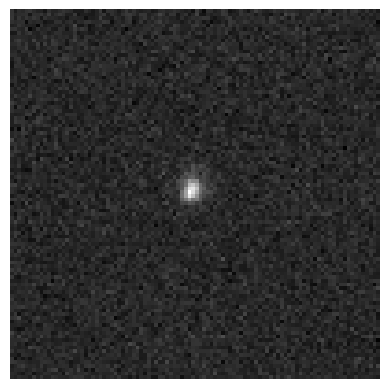

In [3]:
# Prompt examples Build
# Load the .npy file containing the quadruplets of images
id = "1Gb0KKqNEPskOC3ognXF5K9eyFnpZhMpY" #id of the collected_ims.npy
#gdown.download(id=id, output = "data/collected_ims.npy")
id =  "1QmyR4XCdT9SLCP-7yvNsbooPt9r7HIKs"
#gdown.download(id=id, output = "data/collected_vet.npy")

file_path = 'data/collected_ims.npy'
quadruplets = np.load(file_path)

# Load the labels
labels = np.load('data/collected_vet.npy')
labels_df = pd.DataFrame(labels, columns=['label'])
labels_df['label'] = labels_df['label'].apply(lambda x: 'Real' if x > 0.5 else 'Bogus')

# Sample indexes you want to access
sample_indexes= [1, 2, 16, 18, 23, 29]

for i in sample_indexes:
    save_picture(i, quadruplets)

In [4]:
## DESCRIPTION INDEX 1:
desc1 = {
  "class": "Bogus",
  "explanation": "A common example of cosmic ray: the source is a streak of few really bright pixels and not point source-like. There is a clear difference between this cosmic ray source and the actual star in the same image. This is too sharp to be a star."
}

## DESCRIPTION INDEX 2:
desc2= {
  "class": "Bogus",
  "explanation": "This looks very ‘point-source-like’, but the flux in the reference image is negative and therefore this cannot be real. It is most likely a mild ‘dead-pixel’ that has gone unflagged, or a star-image in the flatfield which should have been filtered out. (A positive artefact in the flatfield will show up as a negative image in the science image as we are dividing with the flatfield"
}

## DESCRIPTION INDEX 16:
desc3 = {
  "class": "Real",
  "explanation": "Real: In the new image the central source visible in the reference image has completely disappeared. This leaves a negative, point-source-like object in the difference image."
}

## DESCRIPTION INDEX 18:
desc4 = {
  "class": "Real",
  "explanation": "Real: the source in this sequence has brightened between the reference and the new image and leaves a positive residual in the difference image."
}

## DESCRIPTION INDEX 23:
desc5 = {
  "class": "Bogus",
  "explanation": "Bogus: This is a negative artefact in the new image. Negative fluxes cannot happen in the new or reference image. It is also not point-source-like, but shaped like a ring in the new image."
}

## DESCRIPTION INDEX 29:
desc6 = {
  "class": "Real",
  "explanation": "Real: This is a bright source, point-like, that has appeared in the new image, without any source being present in the difference image at the same location. It is also a point source in the Difference image, as it should."
}

descriptions = [str(desc1), str(desc2), str(desc3), str(desc4), str(desc5), str(desc6)]

In [5]:
PERSONA = ["""<PERSONA>
You are an experienced astrophysicist and your task is to classify the given set of 4 images is real or bogus. You have seen thousands of images during your life time and you are very good at making this classification by look at the images and following the instructions. 
</PERSONA>"""]
INSTRUCTIONS = ["""\n<INSTRUCTIONS>
**1. Purpose**
This is meant as a visual guide to vetting MeerLICHT/BlackGEM data for the Real/Bogus classification. At this stage we are trying to get a high-fidelity machine learning network of what is real and what is bogus. As such it is not necessary to further classify what type of real or what type of bogus it is. But what is real and what is bogus?

**2. Real: Any source that is of astrophysical origin, and variable in time and/or position.**
A real source therefore:
a) has a shape that reflects a **point-source**. Most MeerLICHT data is taken in decent focus conditions, so for us it means that the source is **round**, and has a (visual) extent of ~5-10 pixels. Because conditions vary this number also varies, also between the new and the reference image.
b) is **positive** in either the new or the reference image.
c) can be **variable** in both directions, e.g. fading or brightening between the new and reference image, and is therefore positive or negative in the difference image 
d) can **(dis)appear** between the new and the reference image. This means that in one of the two images there is no source at all, and in the other there is a clear point-source. Note that this can happen on top of an underlying galaxy.

What is the difference between a transient and a variable?
This is a long-standing and fluid debate. For the moment we will adopt the following distinction:
a) a **transient** is an object **with no underlying quiescent point-source counterpart** in the reference image.
b) a **variable** is an object with **an underlying quiescent point-source counterpart** in the reference image.
This is a phenomenological distinction based solely on our own data, not an astrophysical distinction.
E.g. we would all consider a supernova to be a transient (i.e. a destructive, non-repeating, once-offevent). However, in deep images it may have an underlying counterpart (the original star). Or it was detected while bright in the reference image and therefore all the new images shows it to be fading, i.e. a variable.
On the other hand, we can have a dwarf nova outburst occuring in a Cataclysmic Variable with a counterpart that is below our detection limit. Eventhough astrophysically most people would classify a dwarf nova outburst as a variable (i.e. a non-destructive, repeating event), in our data it will look like a transient.
Without any additional information (light curves, deeper images, spectra) we will not be able to make a distinction between these. However, for our real-bogus classification this doesn’t matter. Both are **real**."

**3. Bogus: Any source that is not of astrophysical origin**
Bogus sources are those that are not of astrophysical origin but artefacts, caused by the detector, cosmic-rays, reflections, or the data processing.
A bogus source therefore generally has:
a) a shape that is **not a point-source**: not round, not ‘Gaussian’, with a size ≾5 pixels or ≿10 pixels. Note that a ‘point’ (i.e. one bright pixel), is not a point-source.
b) is **negative** in either the new or the reference image. Any real source needs to show a positive image, i.e. countrates higher than the background sky.

**4. Information provided**
All vetters will be shown three images that are cut-outs of the science images around the suspected source. Therefore it is important to note that **the candidate transient lies in the center of the cut-outs**. Use the full 100x100 pixel image to base your judgement on. If you see that the transient candidate has a very different psf than other stars in the image; or if the image is extended and very close to the edge (possibly a reflection): use this information in your judgement.

The three images are:
1) The **new** image, i.e. the latest science image. This is fully reduced, i.e. debiased and flatfielded.
2) The **reference** image, against which the new image is compared. For the moment the reference images are simply the first image that was taken of a field. The depth and image quality of the reference image therefore does not have to be better/deeper than that of the new image. 
3) The **difference** image. This is the image that is the residual after the new and reference image are  subtracted from each other after being sky-subtracted and scaled/convolved to have matching point- spread-functions. Variations in sky background and seeing should therefore not show up in the difference image. Reals should show up as a point-source object with either positive or negative flux. Residuals due to an imperfect astrometric regridding can still show up. These will generally be seen as ‘ying-yang’ patterns of positive/negative flux. 
</INSTRUCTIONS>

"""]

In [6]:
# Report 3 Real and 3 Bogus examples for the prompt
EXAMPLES = ["<EXAMPLES>\n"]
for i in range(len(sample_indexes)):
    
    str_EX = f"""Example {i+1}:
    """
    all_list = create_ex(sample_indexes[i])
    all_list.insert(0, str_EX)
    all_list.append(descriptions[i])
    all
    for k in all_list:
        EXAMPLES.append(k)
EXAMPLES.append("\n</EXAMPLES>\n")
TASK = ["""<TASK>
Your task is to read the INSTRUCTIONS and look at the 3 images, classify if these 3 images to be Real or Bogus. Provide your thought process to explain how you reasoned to provide the response. Respond in json format
</TASK>\n
"""]

In [21]:
stat_prompt = []
stat_prompt.extend(PERSONA + INSTRUCTIONS + EXAMPLES + TASK) 
pred_df = pd.DataFrame(columns=["label", "prediction", "explanation"])

#table_id = "turan-genai-bb.spacehack.batch_input"
#bq_client = bigquery.Client()
#table = bq_client.get_table(table_id)
random.seed(74)
for t in random.sample(range(17001), 100):

    save_picture(t, quadruplets)
    dyna_prompt = create_ex(t)
    #row = [{"request": batch_data_create(stat_prompt, dyna_prompt)}]
    #errors = bq_client.insert_rows_json(table, row)
    #if errors == []:
    #    print("success")
    response = json.loads(generate(stat_prompt + dyna_prompt).text)
    time.sleep(5)
    print(t)
    pred_df.loc[t] = [labels_df['label'][t], response['class'], response['explanation']]

16884
3722
10461
3952
10129
5959
7097
11515
3935
14472
14965
9104
14614
5598
10267
9147
16473
98
16850
1452
4167
7482
14366
5092
13763
7700
8821
8364
14319
1
6632
5228
1860
7114
10929
1405
669
604
3456
12971
16196
12972
4777
5594
5718
14086
15152
15173
12439
3335
7477
6091
1800
14382
16345
4138
15472
5100
6194
10041
663
9433
10056
16735
9787
10472
5820
12284
3614
6495
5687
11330
13507
7457
10556
2962
3986
15851
6949
4173
9849
9468
4578
1839
15798
2823
9743
15711
2787
13075
1271
6161
5935
13725
16075
16435
4306
14586
4747
16670


<Figure size 640x480 with 0 Axes>

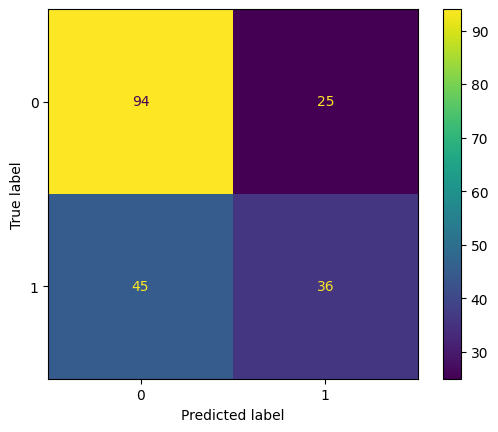

In [3]:
#Save the predictions
#pred_df.to_csv("pred1.csv")
pred_df=pd.read_csv("pred.csv")
plt.clf()
cm = confusion_matrix(pred_df.label, pred_df.prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [23]:
TP = cm[0][0]
TN = cm[0][1]
FP = cm[1][0]
FN = cm[1][1]
print(f"Accuracy is {(TN+TP)/(TN+TP+FP+FN)}")
print(f"Precision is {TP/(TP+FP)}")
print(f"Recall is {TP/(TP+FN)}")

Accuracy is 0.6
Precision is 0.6818181818181818
Recall is 0.703125


In [11]:
pred_df.explanation[1]

'The source is negative in the difference image. Real sources should be positive in either the new or reference image, and can be either positive or negative in the difference image.'

In [10]:
pred_df

,Unnamed: 0,label,prediction,explanation
0,16884,Bogus,Bogus,The source looks like a ying-yang pattern in t...
1,3722,Real,Bogus,The source is negative in the difference image...
2,10461,Bogus,Real,The source is present in both the new and refe...
3,3952,Real,Bogus,"This source looks very point-source-like, but ..."
4,10129,Bogus,Bogus,There is no clear source in the new or referen...
...,...,...,...,...
195,7073,Bogus,Real,The source is present in both new and referenc...
196,8247,Bogus,Bogus,This is a tricky one. While the source looks q...
197,16676,Bogus,Real,The source is brighter in the new image compar...
198,1748,Real,Bogus,The source is present in both new and referenc...
